In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import gym

/home2/dhruv.kapur/anaconda3/envs/rl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1./np.sqrt(fan_in)
    return (-lim, lim)

In [4]:
class Actor(nn.Module):
	def __init__(self, state_dim, action_dim, max_action):
		super(Actor, self).__init__()

		self.l1 = nn.Linear(state_dim, 256)
		self.l2 = nn.Linear(256, 256)
		self.l3 = nn.Linear(256, action_dim)
		
		self.max_action = max_action
		

	def forward(self, state):
		a = F.relu(self.l1(state))
		a = F.relu(self.l2(a))
		return self.max_action * torch.tanh(self.l3(a))


In [5]:
class Critic(nn.Module):
	def __init__(self, state_dim, action_dim):
		super(Critic, self).__init__()

		# Q1 architecture
		self.l1 = nn.Linear(state_dim + action_dim, 256)
		self.l2 = nn.Linear(256, 256)
		self.l3 = nn.Linear(256, 1)

		# Q2 architecture
		self.l4 = nn.Linear(state_dim + action_dim, 256)
		self.l5 = nn.Linear(256, 256)
		self.l6 = nn.Linear(256, 1)


	def forward(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)

		q2 = F.relu(self.l4(sa))
		q2 = F.relu(self.l5(q2))
		q2 = self.l6(q2)
		return q1, q2


	def Q1(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)
		return q1

In [6]:
class ReplayBuffer(object):
	def __init__(self, state_dim, action_dim, max_size=int(1e6)):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0

		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.next_state = np.zeros((max_size, state_dim))
		self.reward = np.zeros((max_size, 1))
		self.not_done = np.zeros((max_size, 1))

		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


	def add(self, state, action, next_state, reward, done):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.next_state[self.ptr] = next_state
		self.reward[self.ptr] = reward
		self.not_done[self.ptr] = 1. - done

		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)


	def sample(self, batch_size):
		ind = np.random.randint(0, self.size, size=batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.not_done[ind]).to(self.device)
		)

In [7]:
import copy

class TD3:

    def __init__(self, state_dim, action_dim, max_action, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):

        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq

        self.total_it = 0

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self, replay_buffer, batch_size=256):

        self.total_it += 1

        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        with torch.no_grad():

            noise = (torch.randn_like(action) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
            next_action = (self.actor_target(next_state) + noise).clamp(-self.max_action, self.max_action)

            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + not_done * self.discount * target_Q

        current_Q1, current_Q2 = self.critic(state, action)

        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        if self.total_it % self.policy_freq == 0:
            actor_loss = -self.critic.Q1(state, self.actor(state)).mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for param. target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    
    def save(self, filename):
        torch.save(self.critic.state_dict(), filename + "_critic")
        torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")

        torch.save(self.actor.state_dict(), filename + "_actor")
        torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")

    def load(self, filename):

        self.critic.load_state_dict(torch.load(filename + "_critic"))
        self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
        self.critic_target

In [8]:
env = gym.make('Pendulum-v1')

In [9]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

In [10]:
replay_buffer = ReplayBuffer(state_dim, action_dim)

In [11]:
state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0

In [12]:
start_timesteps = 100

In [13]:
policy = TD3(state_dim, action_dim, max_action)

In [14]:

rewards = []
for t in range(100_000):

    episode_timesteps += 1

    if t < start_timesteps:
        action = env.action_space.sample()
    else:
        action = (policy.select_action(np.array(state)) + np.random.normal(0, max_action * 0.1, size=action_dim)).clip(-max_action, max_action)
    
    next_state, reward, done, _ = env.step(action)
    done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    if t >= start_timesteps:
        policy.train(replay_buffer)

    if done:
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        rewards.append(episode_reward)
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1

Total T: 200 Episode Num: 1 Episode T: 200 Reward: -1557.810
Total T: 400 Episode Num: 2 Episode T: 200 Reward: -1246.215
Total T: 600 Episode Num: 3 Episode T: 200 Reward: -1706.130
Total T: 800 Episode Num: 4 Episode T: 200 Reward: -1531.479
Total T: 1000 Episode Num: 5 Episode T: 200 Reward: -1512.471
Total T: 1200 Episode Num: 6 Episode T: 200 Reward: -1524.817
Total T: 1400 Episode Num: 7 Episode T: 200 Reward: -1531.626
Total T: 1600 Episode Num: 8 Episode T: 200 Reward: -1518.411
Total T: 1800 Episode Num: 9 Episode T: 200 Reward: -1276.106
Total T: 2000 Episode Num: 10 Episode T: 200 Reward: -1358.532
Total T: 2200 Episode Num: 11 Episode T: 200 Reward: -1522.287
Total T: 2400 Episode Num: 12 Episode T: 200 Reward: -1491.158
Total T: 2600 Episode Num: 13 Episode T: 200 Reward: -1525.486
Total T: 2800 Episode Num: 14 Episode T: 200 Reward: -1442.514
Total T: 3000 Episode Num: 15 Episode T: 200 Reward: -1501.360
Total T: 3200 Episode Num: 16 Episode T: 200 Reward: -1276.246
Total

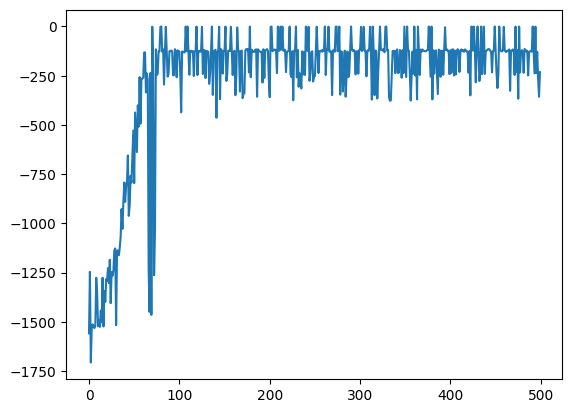

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(len(rewards)), rewards)
plt.show()